# Contraceptive Demand Forecasting 

Demand forecasting of contraceptive products in Côte D’Ivore.

### Dataset: 
Monthly data of 11 contraceptive products stock across 156 health service delivery sites in the public sector health system in Côte D’Ivore, from January 2016 until June 2019.

### Goal:
Forecast contraceptives' stock demand for July, August and September of 2019.

#### Author: Bruna Correa

In [73]:
# Import libraries
import pandas as pd
import numpy as np
from numpy.random import seed
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns

# Import forecast libraries
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima

# Neural networks - LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set sns style
sns.set(style="ticks", color_codes=True)

In [2]:
# Load and check dataset of contraceptives' stock 
stock_df = pd.read_csv('/data/Train.csv')
print(f'Total number of rows: {stock_df.shape[0]}')
print(f'Total number of columns: {stock_df.shape[1]}')
stock_df.head()

Total number of rows: 35753
Total number of columns: 14


,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,0,2,0,10.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,53,9,0,0.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,2,0,0,0.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,43,1,0,0.0


In [3]:
# Features information
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35753 entries, 0 to 35752
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         35753 non-null  int64  
 1   month                        35753 non-null  int64  
 2   region                       35753 non-null  object 
 3   district                     35753 non-null  object 
 4   site_code                    35753 non-null  object 
 5   product_code                 35753 non-null  object 
 6   stock_initial                35753 non-null  int64  
 7   stock_received               35753 non-null  int64  
 8   stock_distributed            35753 non-null  int64  
 9   stock_adjustment             35753 non-null  int64  
 10  stock_end                    35753 non-null  int64  
 11  average_monthly_consumption  35753 non-null  int64  
 12  stock_stockout_days          35753 non-null  int64  
 13  stock_ordered   

In [4]:
# Subselect features that will be used for EDA and forecasting
stock_df_sel = stock_df[['year',
                         'month',
                         'region',
                         'district',
                         'site_code',
                         'product_code',
                         'stock_distributed']].copy()

* Target variable: 'stock_distributed'

## Exploratory Data Analysis

In [5]:
# Check for missing values
stock_df_sel.isnull().mean().sort_values()

year                 0.0
month                0.0
region               0.0
district             0.0
site_code            0.0
product_code         0.0
stock_distributed    0.0
dtype: float64

* No missing values.

In [6]:
# Summarize stock_distributed variable
stock_df_sel['stock_distributed'].describe()

count    35753.000000
mean        14.764327
std         39.848242
min          0.000000
25%          0.000000
50%          1.000000
75%         13.000000
max       1728.000000
Name: stock_distributed, dtype: float64

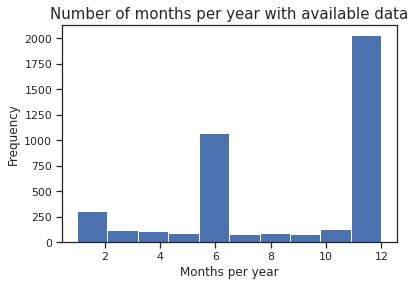

In [7]:
# Group by site_code, product_code, year, to check time range completeness:
stock_df_sel.groupby(['site_code', 'product_code', 'year']).nunique()['month'].plot(kind='hist')
plt.xlabel('Months per year')
plt.title('Number of months per year with available data', fontsize=15);

* There are missing months for some combinations of site_code + product_code!
* Peak at 6 months: for 2019 we only have data until June.
* To do: populate missing months from Jan-2016 until Jun-2019 and impute values.

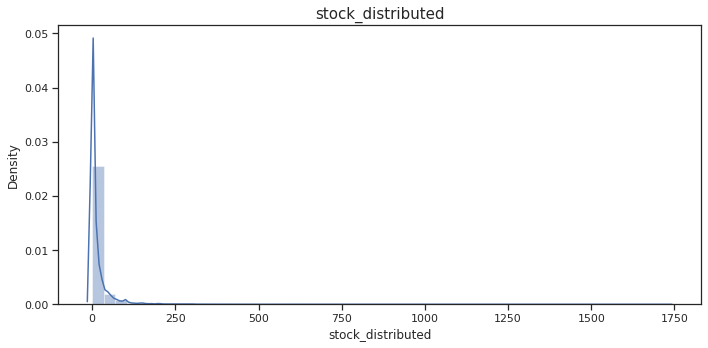

In [8]:
# Plot distribution of stock_distributed variable
plt.figure(figsize=(10, 5))
sns.distplot(a=stock_df_sel['stock_distributed'])
plt.title('stock_distributed', fontsize=15)
plt.tight_layout()

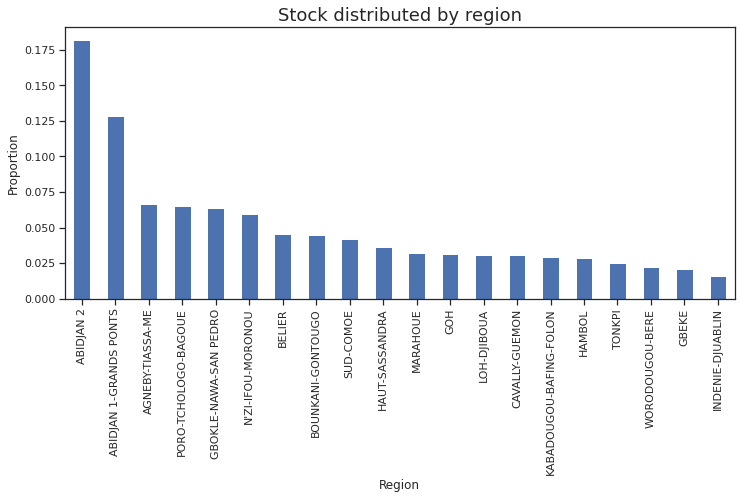

In [9]:
# Explore data by region
stock_df_sel['region'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 5))
plt.title('Stock distributed by region', size=18)
plt.xlabel('Region')
plt.ylabel('Proportion')
plt.show()

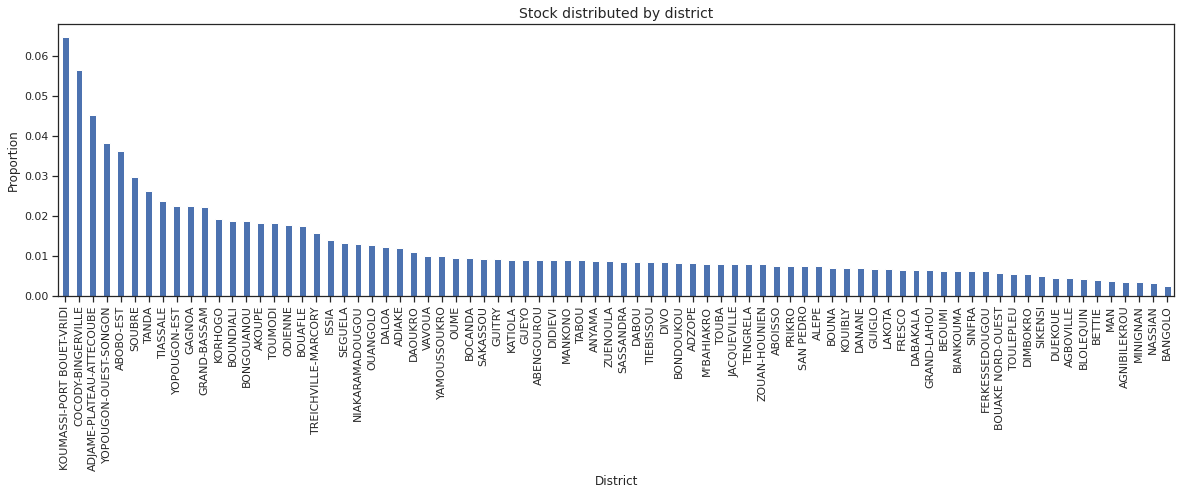

In [10]:
# Explore data by district
stock_df_sel['district'].value_counts(normalize=True).plot(kind='bar', figsize=(20, 5))
plt.title('Stock distributed by district', size=14)
plt.xlabel('District')
plt.ylabel('Proportion')
plt.show()

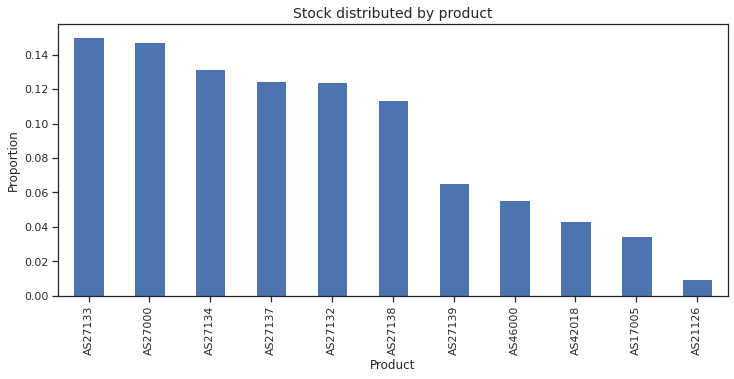

In [11]:
# Explore product's distribution
stock_df_sel['product_code'].value_counts(normalize=True).plot(kind='bar', figsize=(12, 5))
plt.title('Stock distributed by product', size=14)
plt.xlabel('Product')
plt.ylabel('Proportion')
plt.show()

### Temporal EDA

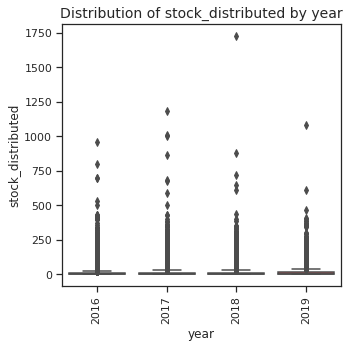

In [12]:
# Plot distribution of stock_distributed by year
plt.figure(figsize=(5, 5))
sns.boxplot(y='stock_distributed', 
            x='year',
            data=stock_df_sel,
            saturation=1)
plt.title('Distribution of stock_distributed by year', fontsize=14)
plt.xticks(rotation='vertical')
plt.tight_layout()

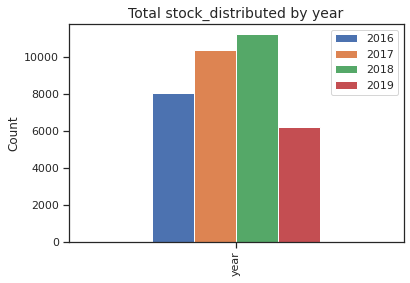

In [13]:
# Plot total stock distributed by year
ax = stock_df_sel['year'].value_counts(normalize=False).sort_index().to_frame().transpose().plot.bar()
ax.set_title('Total stock_distributed by year', fontsize=14)
ax.set_ylabel('Count');

* Distributed stock shows an increase across time from 2016 to 2018
* 2019 data is not complete

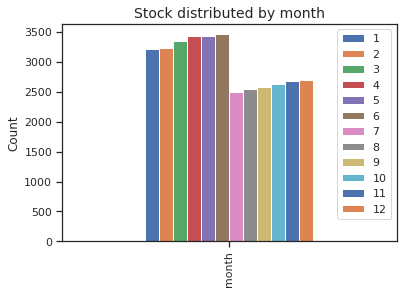

In [14]:
# Plot total stock distributed by month
ax = stock_df_sel['month'].value_counts(normalize=False).sort_index().to_frame().transpose().plot.bar()
ax.set_title('Stock distributed by month',fontsize=14)
ax.set_ylabel('Count');

* For the first 6 months, distributed stock shows an increase across time 
* For the last 6 months, we don't have data from 2019, but the same trend seems to occur

In [15]:
# Check 2019 data to confirm its month range:
stock_df_sel[stock_df_sel['year']==2019]['month'].value_counts(normalize=False).to_frame().sort_index()

,month
1,1014
2,1002
3,1006
4,1068
5,1052
6,1032


* For 2019, there are data until June.

In [16]:
# Create a datetime formated index for time series analyses
idx = pd.to_datetime(
    dict(
        year=stock_df_sel['year'], 
        month=stock_df_sel['month'], 
        day=1 # as we don't have information about the day, fill it with ones
    )
)
# Set dataframe index
stock_df_sel.set_index(idx, inplace=True)

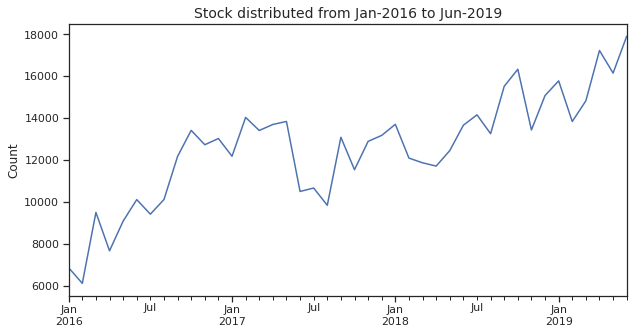

In [17]:
# Plot stock distributed from 2016 to 2019
ax = stock_df_sel.groupby(stock_df_sel.index)['stock_distributed'].sum().plot(figsize=(10,5))
ax.set_title('Stock distributed from Jan-2016 to Jun-2019', fontsize=14)
ax.set_ylabel('Count');

* There is a linear uptrend.
* Trend was disrupted in the middle of 2017.

In [18]:
# Format dataframe to plot a heatmap
monthly = stock_df_sel.resample('M').sum()
monthly['month'] = monthly.index.month
monthly['year'] = monthly.index.year
pv = monthly.pivot("month", "year", "stock_distributed")

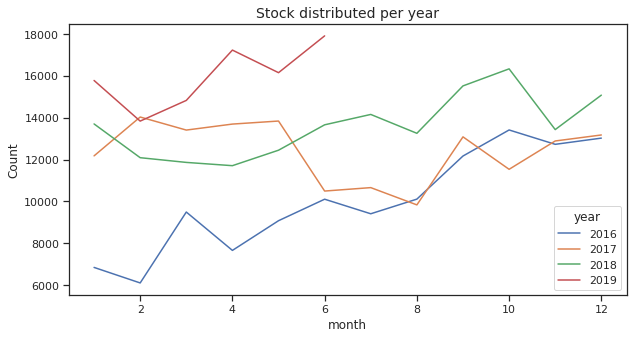

In [19]:
# Plot stock distributed per year
ax = pv.plot(figsize=(10,5))
ax.set_title('Stock distributed per year', fontsize=14)
ax.set_ylabel('Count');

* In 2017 from May to August there was an overall decline in the stock distributed

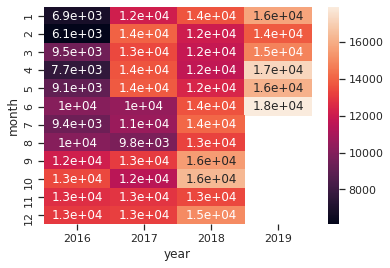

In [20]:
# plot the heatmap
sns.heatmap(pv, annot=True);

* Alternative visualization, similar message:
    * stock_distribution increased from Jan-2016 until Jun-2019
    * there was a decline in 2017 (May - Aug)

## Feature engineering

* For some combinations of site_code/product, there are missing dates.
* Populate missing dates and impute values for stock_distributed.

In [21]:
# 1) Define a function to populate missing months from Jan-2016 until Jun-2019:

def get_ts_range(input_df, date_start, date_end, date_freq):
    
    # Sort data frame by index:
    input_df.sort_index(inplace=True)
    
    # Create an index with every month in the range from Jan-2016 until Jun-2019:
    idx_date = pd.date_range(start=date_start, end=date_end, freq=date_freq)
    
    # Create a new data frame with complete dates and impute it with zeros:
    ts_df = pd.DataFrame(np.zeros(len(idx_date)), index=idx_date)
    
    # Rename col:
    ts_df.columns = ['imputation_col']
    
    # Concatenate input data frame with complete data frame:
    ts_df_comp = pd.concat([ts_df, input_df], axis=1, sort=False)
        
    # Return data frame with complete range:
    return ts_df_comp

In [22]:
# 2) Define a function to impute values in created months
    
def impute_date_vals(input_df, cat_feat_list, target_feat):
    
    # 1) Impute missing values of stock_distributed with interpolation:
    input_df[target_feat].interpolate(method='linear', inplace=True)
    
    # 2) Impute missing values from begining of time series with back propagation:
    input_df[target_feat].fillna(inplace=True, method='bfill')

    # 3) Impute missing values from end of time series with forward propagation:
    input_df[target_feat].fillna(inplace=True, method='ffill')
    
    # 4) Impute missing values of categorical features (region, district, site_code, product_code) with mode:
    input_df[cat_feat_list] = input_df[cat_feat_list].fillna(input_df.mode().iloc[0])
     
    # 5) Return complete data frame with desired features
    return input_df[cat_feat_list+[target_feat]]

In [23]:
# 3) Define function to fill and impute individual time series (site_code & product_code)

def get_complete_df(input_df, date_start, date_end, date_freq, cat_feat_list, target_feat):
    
    # Create output place holder df
    df_complete = pd.DataFrame()
    
    # Loop over data frame and get every 'site_code' & 'product_code' combinations:
    for site, product in input_df.groupby(['site_code','product_code']).indices:
        
        # Create a dataframe for each time series:
        single_ts_df = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]
        
        # Add missing months:
        single_ts_df_complete_dates = get_ts_range(single_ts_df, 
                                                   date_start, 
                                                   date_end, 
                                                   date_freq)
        
        # Impute missing values:
        single_ts_df_complete_dates_vals = impute_date_vals(single_ts_df_complete_dates, 
                                                            cat_feat_list,
                                                            target_feat)
        
        # Concatenate individual data frames togetherL
        df_complete = pd.concat([df_complete, single_ts_df_complete_dates_vals[cat_feat_list+[target_feat]]])
    
    # Return complete data frame
    return df_complete

In [24]:
# Run functions to get a populated and imputed data frame:
stock_df_sel_comp = get_complete_df(input_df = stock_df_sel, 
                                    date_start = '2016-01-01', 
                                    date_end = '2019-06-01', 
                                    date_freq = 'MS',
                                    cat_feat_list = ['region', 'district', 'site_code', 'product_code'],
                                    target_feat = 'stock_distributed')

In [25]:
# Df info:
stock_df_sel_comp.info

<bound method DataFrame.info of                              region   district site_code product_code  \
2016-01-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-02-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-03-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-04-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
2016-05-01         AGNEBY-TIASSA-ME  AGBOVILLE     C1004      AS21126   
...                             ...        ...       ...          ...   
2019-02-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-03-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-04-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-05-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   
2019-06-01  KABADOUGOU-BAFING-FOLON   MINIGNAN     C5066      AS46000   

            stock_distributed  
2016-01-01                0.0  
2016-02-01                0

In [26]:
# Group data by index to check completeness:
stock_df_sel_comp.groupby(stock_df_sel_comp.index).nunique()

,region,district,site_code,product_code,stock_distributed
2016-01-01,20,80,155,11,89
2016-02-01,20,80,155,11,107
2016-03-01,20,80,155,11,106
2016-04-01,20,80,155,11,111
2016-05-01,20,80,155,11,113
2016-06-01,20,80,155,11,121
2016-07-01,20,80,155,11,107
2016-08-01,20,80,155,11,113
2016-09-01,20,80,155,11,113
2016-10-01,20,80,155,11,114


In [28]:
# Check for missing values:
stock_df_sel_comp.isnull().mean().sort_values()

region               0.0
district             0.0
site_code            0.0
product_code         0.0
stock_distributed    0.0
dtype: float64

## Forecasting Models

### ARIMA - Models - Baseline

In [29]:
# Check data frame formating:
stock_df_sel_comp.head()

,region,district,site_code,product_code,stock_distributed
2016-01-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-02-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-03-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-04-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0
2016-05-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,AS21126,0.0


In [ ]:
# Define function to run ARIMA with auto_arima for order selection:

def run_auto_arima(input_df, target_feat, train_start, train_end, pred_months):
   
    # Create a placeholder to save prediction losses:
    error = []

    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:

        # Create a dataframe for each combination of site_code + product code:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'

        # Split data in train and test (last 3 months):
        train = single_ts.loc[train_start:train_end][target_feat]
        test = single_ts.loc[train_end:][target_feat]

        # Run auto_arima to determine ARIMA orders (p,d,q):
        arima_model = auto_arima(train, 
                                 start_p=0, 
                                 start_d=0,
                                 start_q=0,
                                 max_p=6,
                                 max_d=6,
                                 max_q=6,
                                 seasonal=False,
                                 random_state=2020)
        #arima_model.summary()

        # Use model to generate predictions for a given number of months:
        prediction = arima_model.predict(n_periods=pred_months)

        # Create predictions data frame to plot:
        #prediction_df = pd.DataFrame(prediction, index=test.index)
        #oprediction_df.columns = [str('predicted_'+ target_feat)]

        # Plot: train, test and predicted values:
        #plt.figure(figsize=(8,5))
        #plt.plot(train)
        #plt.plot(test)
        #plt.plot(prediction_df)
        #plt.xlabel('Date')
        #plt.ylabel('stock_distributed')
        #plt.title(site + '_' + product + ': stock distributed across time')
        #plt.legend(['Train', 'Test', 'Prediction'])
        #plt.savefig('/plots/plot_'+ site + '_' + product + '.pdf')

        # Compare predictions with test, compute RMSE and append to losses:
        error.append(rmse(test, prediction))
    
    # Return average RMSE for all model predictions:
    return np.mean(error)

In [ ]:
# Run ARIMA and get average loss for all time series predictions:
avg_rmse_arima = run_auto_arima(input_df = stock_df_sel_comp, 
                                target_feat = 'stock_distributed',
                                train_start = '2016-01-01',
                                train_end = '2019-04-01',
                                pred_months = 3) # predictions for 3 months

In [ ]:
# Create a dictionary to store losses:
loss_dict = {'rmse_arima': avg_rmse_arima}
loss_dict

In [ ]:
loss_dict = {'rmse_arima': 9.06582051174892}

In [ ]:
# Since trend was interrupted in 2017, try to do predictions starting from 2017-August
# avg_rmse_arima_2017 = run_auto_arima(input_df = stock_df_sel_comp, 
#                                      target_feat = 'stock_distributed',
#                                      train_start = '2017-08-01', # change start month for Aug-2017
#                                      train_end = '2019-04-01',
#                                      pred_months = 3) # predictions for 3 months

In [ ]:
# Add to losses dict:
# loss_dict['rmse_arima_2017'] = avg_rmse_arima_2017
# pd.DataFrame(loss_dict, index=[0])

### Neural networks - RNN LSTM

In [ ]:
# Set seed
seed(2020)

# Define model:
n_input = 38
n_features = 1
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

# Define function to build and get predictions from recurrent neural network with LSTM:

def my_lstm_model(input_df, input_model, n_input, n_features, target_feat, n_epochs):

    # Create a placeholder to save prediction losses:
    error = []

    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:
    
        # Create a data frame per each time series:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'
    
        # Train / test split:
        train = single_ts[[target_feat]].iloc[:39]
        test = single_ts[[target_feat]].iloc[39:]
    
        # Scale data:
        scaler = MinMaxScaler()

        # Fit on the train data only, otherwise we using information from the test set
        scaler.fit(train)

        # Scale train and test:
        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)
    
        # Define time series generator:
        generator = TimeseriesGenerator(scaled_train, 
                                        scaled_train, 
                                        length=n_input, 
                                        batch_size=1)

        # Fit model:
        input_model.fit_generator(generator, 
                                  epochs=n_epochs,
                                  verbose=0)

        # Plot loss per epoch
        #loss_per_epoch = model.history.history['loss']
        #plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

        # Test predictions:
        test_predictions = []

        first_eval_batch = scaled_train[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))

        # Loop to get predictions:
        for i in range(len(test)):
    
            # Get prediction for 1 month ahead:
            current_pred = model.predict(current_batch)[0]
    
            # Store prediction:
            test_predictions.append(current_pred) 
    
            # Update batch: include prediction and drop first value:
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
        # Re-scale predictions to match original scale:
        true_predictions = scaler.inverse_transform(test_predictions)
    
        # Add predictions to test df to calculate loss:
        test['predictions'] = true_predictions
    
        # Plot test vs. predictions:
        #test.plot(figsize=(5,5))
    
        # Compute RMSE:
        error.append(rmse(test[target_feat], test['predictions']))
        
        # Save model:
        #model.save(product + '_' + site + '_rnn_model.h5')
    
    # Return average RMSE for all model predictions:
    return np.mean(error)

In [ ]:
# Run lstm model
avg_rmse_lstm = my_lstm_model(input_df = stock_df_sel_comp, 
                              input_model = model,
                              n_input = n_input, 
                              n_features = n_features, 
                              target_feat = 'stock_distributed',
                              n_epochs = 10)

In [ ]:
# Add to losses dict:
loss_dict['rmse_rnn_lstm'] = avg_rmse_lstm
pd.DataFrame(loss_dict, index=[0])

## Forecasting

In [30]:
mini_df = stock_df_sel_comp[stock_df_sel_comp['site_code'] == 'C1015']
mini_df

,region,district,site_code,product_code,stock_distributed
2016-01-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS17005,0.0
2016-02-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS17005,0.0
2016-03-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS17005,0.0
2016-04-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS17005,0.0
2016-05-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS17005,0.0
...,...,...,...,...,...
2019-02-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS46000,33.0
2019-03-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS46000,18.0
2019-04-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS46000,33.0
2019-05-01,ABIDJAN 2,KOUMASSI-PORT BOUET-VRIDI,C1015,AS46000,51.0


In [88]:
# Set seed
seed(2020)

# Fit model using full data set to forecast 3 months in the future:

# Define model:
n_input = 41
n_features = 1
model = Sequential()
model.add(LSTM(80, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

# Define function to build and get predictions from recurrent neural network with LSTM:

def rnn_lstm_model(input_df, input_model, n_input, n_features, target_feat, n_epochs):

    # Create a placeholder df to save predictions:
    final_predictions = pd.DataFrame()

    # Loop over data frame to get predictions for each individual time series:
    for site, product in input_df.groupby(['site_code','product_code']).indices:
    
        # Create a data frame per each time series:
        single_ts = input_df[(input_df['site_code'] == site) & (input_df['product_code'] == product)]

        # Set index to monthly data:
        single_ts.index.freq = 'MS'
        
        # Scale data:
        scaler = MinMaxScaler()

        # Fit scaler:
        scaler.fit(single_ts[[target_feat]])

        # Scale data:
        scaled_df = scaler.transform(single_ts[[target_feat]])
    
        # Define time series generator:
        generator = TimeseriesGenerator(scaled_df, 
                                        scaled_df, 
                                        length=n_input, 
                                        batch_size=1)

        # Fit model:
        input_model.fit_generator(generator, 
                                  epochs=n_epochs,
                                  verbose=1)

        # Plot loss per epoch
        #loss_per_epoch = model.history.history['loss']
        #plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

        # Save predictions:
        out_predictions = []

        first_eval_batch = scaled_df[-n_input:]
        current_batch = first_eval_batch.reshape((1, n_input, n_features))

        # Loop to get predictions:
        for i in range(3):
    
            # Get prediction for 1 month ahead:
            current_pred = model.predict(current_batch)[0]
    
            # Store prediction:
            out_predictions.append(current_pred) 
    
            # Update batch: include prediction and drop first value:
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
        # Re-scale predictions to match original scale:
        true_predictions = scaler.inverse_transform(out_predictions)
    
        # Add ID to predictions do build output data frame:
        pred_id = [['2019 X 7 X ' + site + ' X ' + product, true_predictions[0,0]],
                   ['2019 X 8 X ' + site + ' X ' + product, true_predictions[1,0]],
                   ['2019 X 9 X ' + site + ' X ' + product, true_predictions[2,0]]]
        predictions_df = pd.DataFrame(pred_id, columns=['ID','model_prediction']) 
        
        # Buil output predictions data frame:
        final_predictions = pd.concat([final_predictions,predictions_df])
        
        # Save model:
        #model.save(product + '_' + site + '_rnn_full_model.h5')
    
    # Return average predictions data frame:
    return final_predictions.reset_index(drop=True)

In [ ]:
# Run final rnn lstm model and get predictions
out_pred_df = rnn_lstm_model(input_df = stock_df_sel_comp, 
                             input_model = model,
                             n_input = n_input, 
                             n_features = n_features, 
                             target_feat = 'stock_distributed',
                             n_epochs = 10)

Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 5ms/step - loss: 0.1134
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.1065
Epoch 3/10
1/1 [==================

1/1 [==============================] - 0s 2ms/step - loss: 1.0285e-05
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 7.3179e-07
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 7.9506e-04
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 5.1664e-04
Epoch 7/10
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0276
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 3/1

1/1 [==============================] - 0s 2ms/step - loss: 1.8867e-06
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 9.5978e-05
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 3.7561e-04
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 7.6180e-04
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 1.6151e-04
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 1.3755e-04
Epoch 3/10
1/1 [==============================] - 0s 1ms/step - loss: 1.1735e-04
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0027e-04
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 8.5829e-05
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 7.3900e-05
Epoch 7/10
1/1 [==============================

1/1 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 8.4175e-05
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 1.1481e-04
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 1.4587e-04
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 1.7634e-04
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 2.0535e-04
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 2.3246e-04
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 2.5741e-04
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 2.7997e-04
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 3.0002e-04
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 3.1753e-04
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.1485
Epoch 2/10
1/1 [==============================

1/1 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0100
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0814
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0795
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0771
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0743
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0710
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0674
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0633
Epoch 8/1

1/1 [==============================] - 0s 2ms/step - loss: 0.1003
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1003
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: 0.1003
Epoch 1/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] -

1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4082
Epoch 2/10
1/1 [==========================

1/1 [==============================] - 0s 3ms/step - loss: 0.1111
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.1111
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.1111
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.1111
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 0.1111
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1111
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.1111
Epoch 10/10
1/1 [==============================] - 0s 1ms/step - loss: 0.1111
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0464
Epoch 2/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0464
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0464
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0464
Epoch 6/1

1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3661
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3661
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3661
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.3661
Epoch 10/

1/1 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0585
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0559
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 4/1

1/1 [==============================] - 0s 4ms/step - loss: 4.7259e-04
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 4.7259e-04
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 4.7259e-04
Epoch 7/10
1/1 [==============================] - 0s 11ms/step - loss: 4.7259e-04
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 4.7259e-04
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 4.7259e-04
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 4.7259e-04
Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.1385
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1385
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1385
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1385
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.1385
Epoch 6/10
1/1 [==============================] - 0s 3ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.3531
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.3531
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3531
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3531
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3633
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3633
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3633
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3633
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3633
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3633
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.3633
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3633
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 0.3633
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 0.3633
Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0143
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 3/1

1/1 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0465
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0465
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0237
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 6/1

1/1 [==============================] - 0s 2ms/step - loss: 0.1878
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.1878
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.1878
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1878
Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.6944
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.6944
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.6944
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6944
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.6944
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.6944
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.6944
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.6944
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.6944
Epoch 10/

1/1 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 1/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0605
Epoch 2/10
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4545
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.4545
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.4545
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 

1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0638
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0638
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0638
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0638
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0638
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0638
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e

1/1 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.3265
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3265
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.3265
Epoch 1/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7932
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7932
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.7932
Epoch 4/1

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [======================

1/1 [==============================] - 0s 6ms/step - loss: 0.0160
Epoch 9/10
1/1 [==============================] - 0s 12ms/step - loss: 0.0160
Epoch 10/10
1/1 [==============================] - 0s 11ms/step - loss: 0.0160
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2500
Epoch 3/10
1/1 [==============================] - 0s 12ms/step - loss: 0.2500
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 0.2500
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2500
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2500
Epoch 10/10
1/1 [==============================] - 0s 11ms/step - loss: 0.2500
Epo

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 3/10
1/1 [==============================

1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 6/10
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0463
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0463
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 

1/1 [==============================] - 0s 3ms/step - loss: 4.3403e-04
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 4.3403e-04
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 4.3403e-04
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 4.3403e-04
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 4.3403e-04
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 4.3403e-04
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 4.3403e-04
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 4.3403e-04
Epoch 10/10
1/1 [==============================] - 0s 3ms/step - loss: 4.3403e-04
Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [======================

1/1 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Epoch 1/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [======================

1/1 [==============================] - 0s 4ms/step - loss: 0.1728
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1728
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1728
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.1728
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0083
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 8/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 9/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 10/

1/1 [==============================] - 0s 4ms/step - loss: 0.0315
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 7/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 9/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0315
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.2500
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.2500
Epoch 5/1

1/1 [==============================] - 0s 2ms/step - loss: 0.5625
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.5625
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.5625
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.5625
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.5625
Epoch 10/10
1/1 [==============================] - 0s 5ms/step - loss: 0.5625
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 2/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0506
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0506
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 8/1

1/1 [==============================] - 0s 2ms/step - loss: 0.3543
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.3543
Epoch 1/10
1/1 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 6/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 10/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 1/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0424
Epoch 2/

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00
Epoch 6/10


In [76]:
out_pred_df.head()

,ID,model_prediction
0,2019 X 7 X C1015 X AS17005,0.000000
1,2019 X 8 X C1015 X AS17005,0.000000
2,2019 X 9 X C1015 X AS17005,0.000000
3,2019 X 7 X C1015 X AS21126,0.000000
4,2019 X 8 X C1015 X AS21126,0.000000
5,2019 X 9 X C1015 X AS21126,0.000000
6,2019 X 7 X C1015 X AS27000,9.078192
7,2019 X 8 X C1015 X AS27000,8.719071
8,2019 X 9 X C1015 X AS27000,8.342018
9,2019 X 7 X C1015 X AS27132,7.083959


### Save final predictions

In [77]:
# Import 'SampleSubmission.csv':
sample_submission = pd.read_csv("/data/SampleSubmission.csv")
sample_submission.head()

,ID,prediction
0,2019 X 7 X C4001 X AS21126,0
1,2019 X 7 X C4001 X AS27134,0
2,2019 X 7 X C4001 X AS27132,0
3,2019 X 7 X C4001 X AS27000,0
4,2019 X 7 X C4001 X AS27137,0


In [87]:
# Match predictions with SampleSubmission:
out_pred = pd.concat([sample_submission.set_index('ID'), 
                      out_pred_df.set_index('ID')], 
                     axis=1, 
                     join='inner').reset_index().drop(columns='prediction')
out_pred.columns = ['ID', 'prediction']
out_pred.head()

,ID,prediction
0,2019 X 7 X C1015 X AS42018,0.000000
1,2019 X 7 X C1015 X AS21126,0.000000
2,2019 X 7 X C1015 X AS46000,10.902750
3,2019 X 7 X C1015 X AS17005,0.000000
4,2019 X 7 X C1015 X AS27134,12.448788


In [86]:
# Output .csv file with final predictions:
out_pred.to_csv('/data/PredictionSubmission.csv', index = False)